In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print("🎉 You're ready to start!")

In [7]:
# Load training and test data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print("📊 DATA LOADED SUCCESSFULLY!")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nFirst 5 rows of training data:")
train_df.head()

📊 DATA LOADED SUCCESSFULLY!
Training data shape: (517754, 14)
Test data shape: (172585, 13)

First 5 rows of training data:


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
# Check data types and missing values
print("📋 Data Information:")
print(train_df.info())
print("\n" + "="*50)

print("\n❓ Missing Values:")
print(train_df.isnull().sum())
print("\n" + "="*50)

print("\n📊 Statistical Summary:")
train_df.describe()

📋 Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtype

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


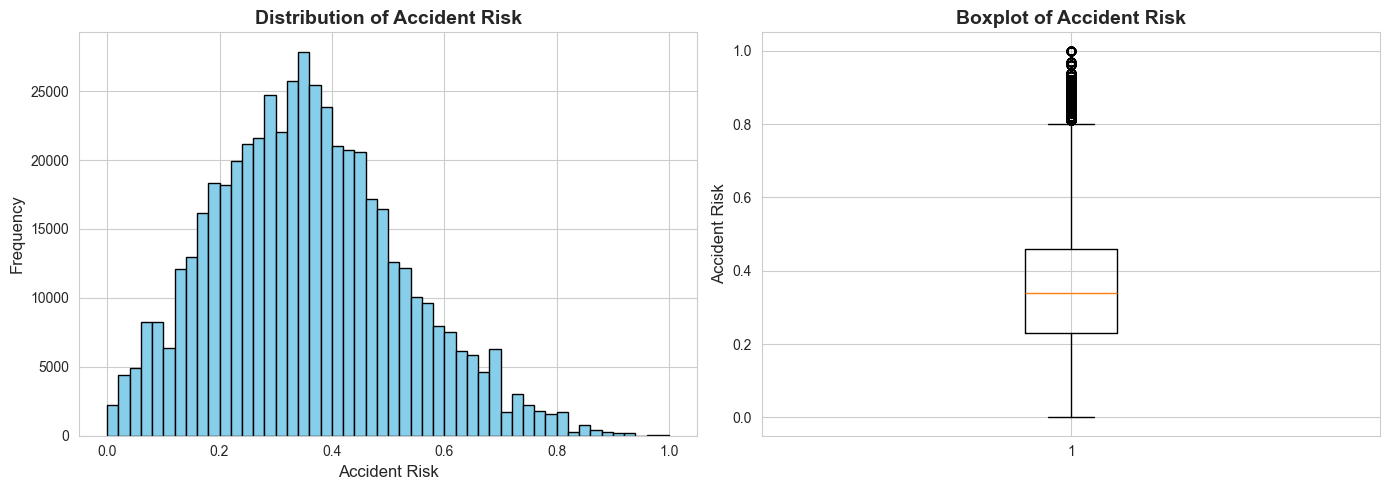

📊 Target Variable Statistics:
   Mean: 0.3524
   Median: 0.3400
   Min: 0.0000
   Max: 1.0000


In [9]:
# Distribution of accident risk
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['accident_risk'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Accident Risk', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Accident Risk', fontsize=14, fontweight='bold')

# Boxplot
axes[1].boxplot(train_df['accident_risk'], vert=True)
axes[1].set_ylabel('Accident Risk', fontsize=12)
axes[1].set_title('Boxplot of Accident Risk', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Target Variable Statistics:")
print(f"   Mean: {train_df['accident_risk'].mean():.4f}")
print(f"   Median: {train_df['accident_risk'].median():.4f}")
print(f"   Min: {train_df['accident_risk'].min():.4f}")
print(f"   Max: {train_df['accident_risk'].max():.4f}")

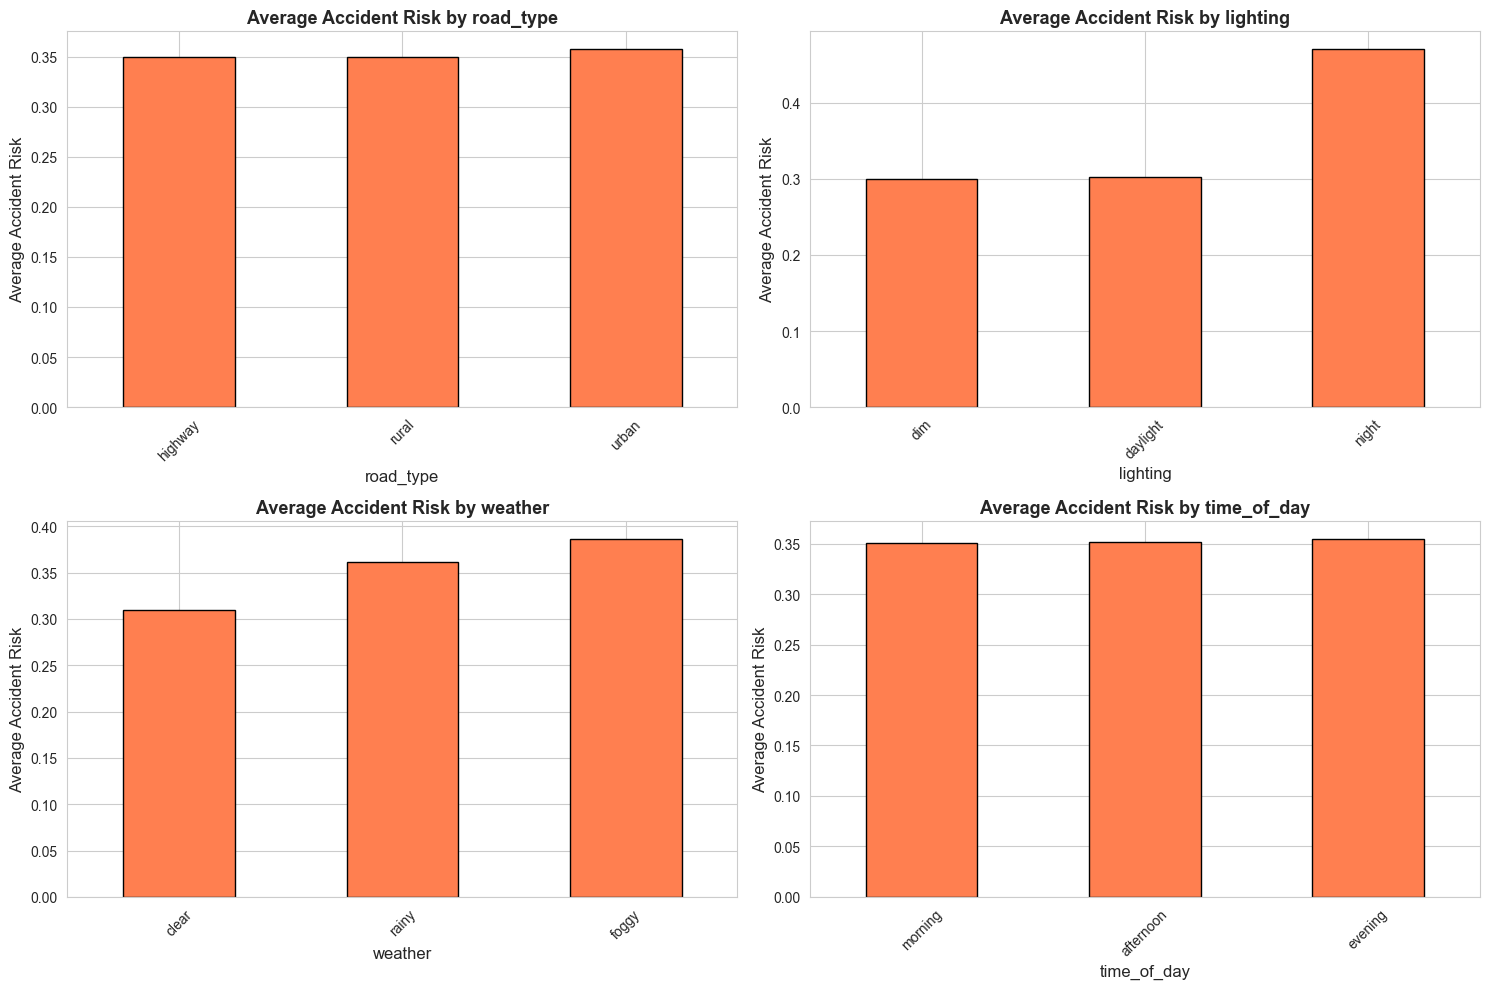

In [14]:
# Analyze how different conditions affect accident risk
categorical_features = ['road_type', 'lighting', 'weather', 'time_of_day']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    avg_risk = train_df.groupby(feature)['accident_risk'].mean().sort_values()
    avg_risk.plot(kind='bar', ax=axes[i], color='coral', edgecolor='black')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Average Accident Risk', fontsize=12)
    axes[i].set_title(f'Average Accident Risk by {feature}', fontsize=13, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

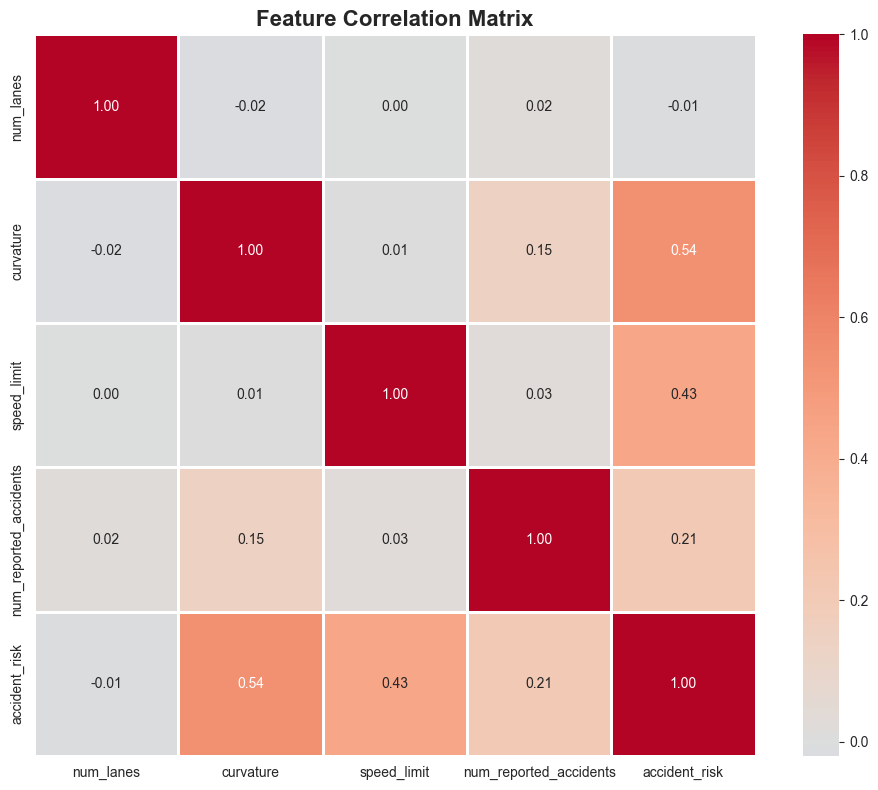

💡 Interpretation:
   - Values close to +1 = strong positive correlation
   - Values close to -1 = strong negative correlation
   - Values close to 0 = no correlation


In [15]:
# Check correlations between numerical features
numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
correlation_data = train_df[numerical_features + ['accident_risk']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   - Values close to +1 = strong positive correlation")
print("   - Values close to -1 = strong negative correlation")
print("   - Values close to 0 = no correlation")

In [16]:
# Separate features and target
X_train = train_df.drop(['id', 'accident_risk'], axis=1)
y_train = train_df['accident_risk']
X_test = test_df.drop('id', axis=1)

print(f"✅ Features shape: {X_train.shape}")
print(f"✅ Target shape: {y_train.shape}")
print(f"✅ Test features shape: {X_test.shape}")

# Identify column types
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📝 Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"📝 Numerical columns ({len(numerical_cols)}): {numerical_cols}")

✅ Features shape: (517754, 12)
✅ Target shape: (517754,)
✅ Test features shape: (172585, 12)

📝 Categorical columns (8): ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
📝 Numerical columns (4): ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


In [17]:
# Convert categorical text into numbers that ML models can understand
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Combine train and test to ensure all categories are covered
    combined = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined.astype(str))
    
    # Transform both train and test
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    
    print(f"✅ Encoded {col}")

print("\n🎉 All categorical variables encoded!")
print("\nExample - road_type encoding:")
print(f"   highway → {label_encoders['road_type'].transform(['highway'])[0]}")
print(f"   rural → {label_encoders['road_type'].transform(['rural'])[0]}")
print(f"   urban → {label_encoders['road_type'].transform(['urban'])[0]}")

✅ Encoded road_type
✅ Encoded lighting
✅ Encoded weather
✅ Encoded road_signs_present
✅ Encoded public_road
✅ Encoded time_of_day
✅ Encoded holiday
✅ Encoded school_season

🎉 All categorical variables encoded!

Example - road_type encoding:
   highway → 0
   rural → 1
   urban → 2


In [18]:
# Split training data into train and validation sets
# This helps us test our model before submitting
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"📊 Data Split:")
print(f"   Training set: {X_train_split.shape[0]} samples")
print(f"   Validation set: {X_val_split.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")

📊 Data Split:
   Training set: 414203 samples
   Validation set: 103551 samples
   Test set: 172585 samples


In [19]:
# Build and train Random Forest model
print("🌲 Training Random Forest Model...")
print("This may take 1-2 minutes... ⏳")

rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of decision trees
    max_depth=15,          # Maximum depth of each tree
    min_samples_split=10,  # Minimum samples needed to split
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    verbose=1              # Show progress
)

rf_model.fit(X_train_split, y_train_split)
print("\n✅ Random Forest trained successfully!")

# Make predictions on validation set
rf_predictions = rf_model.predict(X_val_split)

# Evaluate the model
rf_mse = mean_squared_error(y_val_split, rf_predictions)
rf_mae = mean_absolute_error(y_val_split, rf_predictions)
rf_r2 = r2_score(y_val_split, rf_predictions)

print("\n📊 Random Forest Results:")
print(f"   Mean Squared Error (MSE): {rf_mse:.6f}")
print(f"   Mean Absolute Error (MAE): {rf_mae:.6f}")
print(f"   R² Score: {rf_r2:.6f}")
print("\n💡 Lower MSE/MAE is better, Higher R² is better (max = 1.0)")

🌲 Training Random Forest Model...
This may take 1-2 minutes... ⏳


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s



✅ Random Forest trained successfully!

📊 Random Forest Results:
   Mean Squared Error (MSE): 0.003219
   Mean Absolute Error (MAE): 0.043979
   R² Score: 0.883404

💡 Lower MSE/MAE is better, Higher R² is better (max = 1.0)


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [20]:
# Build and train Ridge Regression model (simpler, faster)
print("📈 Training Ridge Regression Model...")

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_split, y_train_split)
print("✅ Ridge Regression trained successfully!")

# Make predictions
ridge_predictions = ridge_model.predict(X_val_split)

# Evaluate
ridge_mse = mean_squared_error(y_val_split, ridge_predictions)
ridge_mae = mean_absolute_error(y_val_split, ridge_predictions)
ridge_r2 = r2_score(y_val_split, ridge_predictions)

print("\n📊 Ridge Regression Results:")
print(f"   Mean Squared Error (MSE): {ridge_mse:.6f}")
print(f"   Mean Absolute Error (MAE): {ridge_mae:.6f}")
print(f"   R² Score: {ridge_r2:.6f}")

📈 Training Ridge Regression Model...
✅ Ridge Regression trained successfully!

📊 Ridge Regression Results:
   Mean Squared Error (MSE): 0.007822
   Mean Absolute Error (MAE): 0.070809
   R² Score: 0.716707


📊 MODEL COMPARISON:
                       MSE       MAE        R²
Random Forest     0.003219  0.043979  0.883404
Ridge Regression  0.007822  0.070809  0.716707


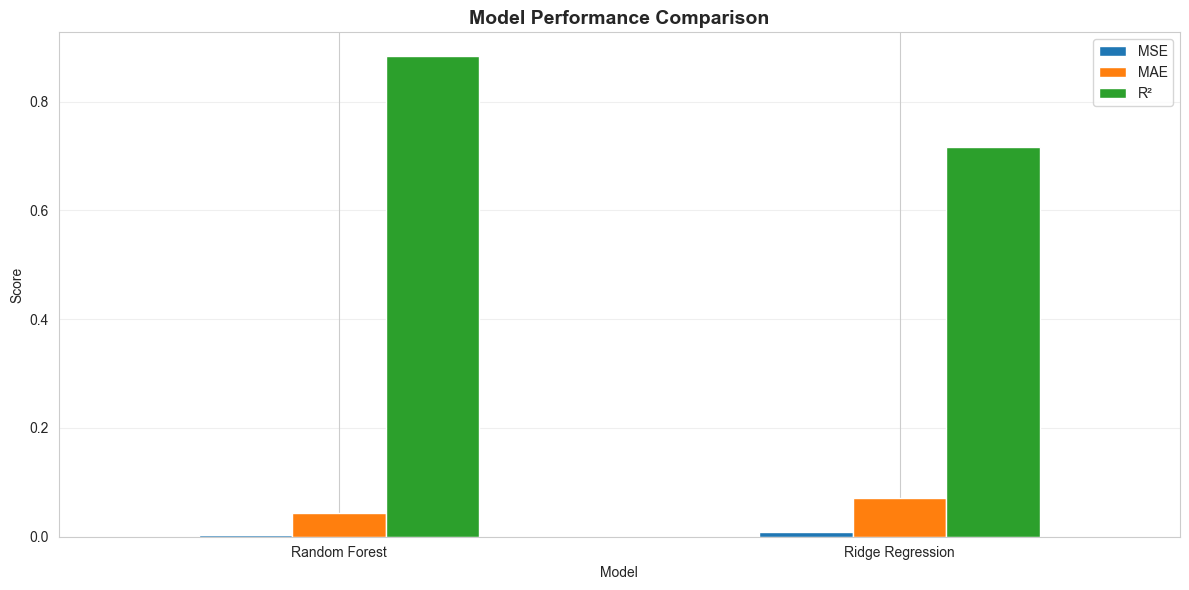


🏆 Best Model: Random Forest


In [21]:
# Compare both models side by side
results = {
    'Random Forest': {'MSE': rf_mse, 'MAE': rf_mae, 'R²': rf_r2},
    'Ridge Regression': {'MSE': ridge_mse, 'MAE': ridge_mae, 'R²': ridge_r2}
}

comparison_df = pd.DataFrame(results).T
print("📊 MODEL COMPARISON:")
print("="*50)
print(comparison_df)

# Visualize comparison
comparison_df.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Determine best model
best_model_name = 'Random Forest' if rf_r2 > ridge_r2 else 'Ridge Regression'
print(f"\n🏆 Best Model: {best_model_name}")

🎯 TOP 10 MOST IMPORTANT FEATURES:
                   Feature  Importance
2                curvature    0.361988
4                 lighting    0.262280
3              speed_limit    0.247697
5                  weather    0.074772
11  num_reported_accidents    0.037636
1                num_lanes    0.003653
8              time_of_day    0.002708
0                road_type    0.002684
7              public_road    0.001735
9                  holiday    0.001722


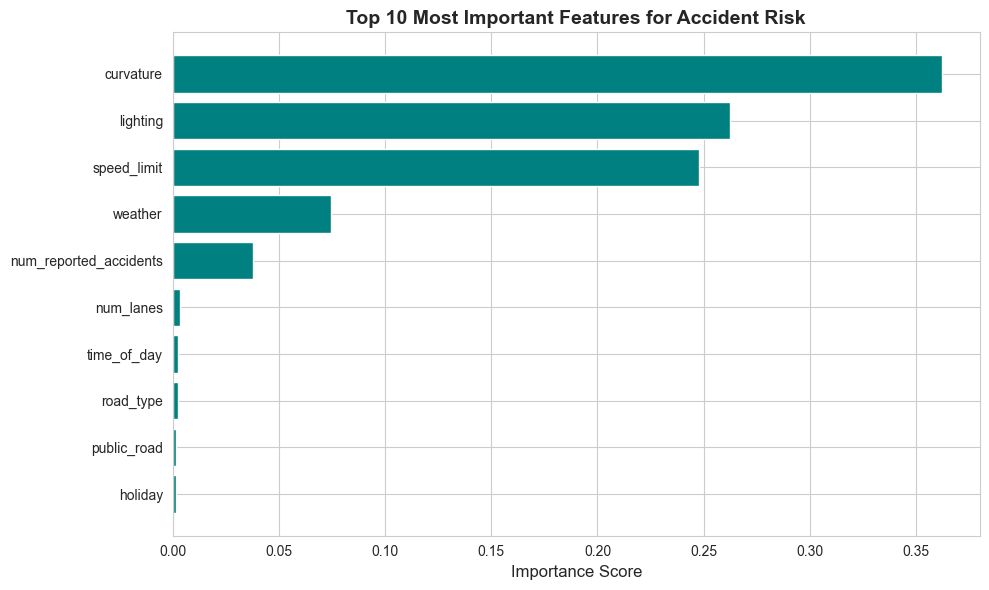

In [22]:
# See which features matter most (Random Forest only)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("🎯 TOP 10 MOST IMPORTANT FEATURES:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Most Important Features for Accident Risk', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
# Train on ALL training data (not just the split)
print("🎓 Training final model on FULL training data...")

final_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

final_model.fit(X_train, y_train)
print("\n✅ Final model trained on all {} samples!".format(len(X_train)))

🎓 Training final model on FULL training data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s



✅ Final model trained on all 517754 samples!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished


In [24]:
# Predict on test data
print("🔮 Making predictions on test data...")
test_predictions = final_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'accident_risk': test_predictions
})

# Save to CSV
submission.to_csv('my_submission.csv', index=False)
print("✅ Predictions saved to: my_submission.csv")

# Display sample predictions
print("\n📋 Sample Predictions (first 10):")
print(submission.head(10))

print("\n📊 Prediction Statistics:")
print(f"   Mean predicted risk: {test_predictions.mean():.4f}")
print(f"   Min predicted risk: {test_predictions.min():.4f}")
print(f"   Max predicted risk: {test_predictions.max():.4f}")

🔮 Making predictions on test data...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


✅ Predictions saved to: my_submission.csv

📋 Sample Predictions (first 10):
       id  accident_risk
0  517754       0.320435
1  517755       0.116381
2  517756       0.172471
3  517757       0.313251
4  517758       0.410891
5  517759       0.453996
6  517760       0.265390
7  517761       0.195436
8  517762       0.367538
9  517763       0.325351

📊 Prediction Statistics:
   Mean predicted risk: 0.3517
   Min predicted risk: 0.0253
   Max predicted risk: 0.8790


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [ ]:
# 💾 SAVE MODEL FOR WEB APP DEPLOYMENT
# This saves the trained model and encoders so they can be used in the web interface

import joblib
import os

# Create model directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')
    print("✅ Created 'model' directory")

# Save the final trained model
joblib.dump(final_model, 'model/accident_risk_model.pkl')
print("✅ Model saved to: model/accident_risk_model.pkl")

# Save the label encoders
joblib.dump(label_encoders, 'model/label_encoders.pkl')
print("✅ Encoders saved to: model/label_encoders.pkl")

print("\n🎉 Model files saved successfully!")
print("\n🚀 Next Steps:")
print("   1. Run the web app: streamlit run app.py")
print("   2. Or run: python train_and_save_model.py")
print("   3. Deploy to Streamlit Cloud (see DEPLOYMENT.md)")

print("\n💡 These files are needed for the web application to work!")

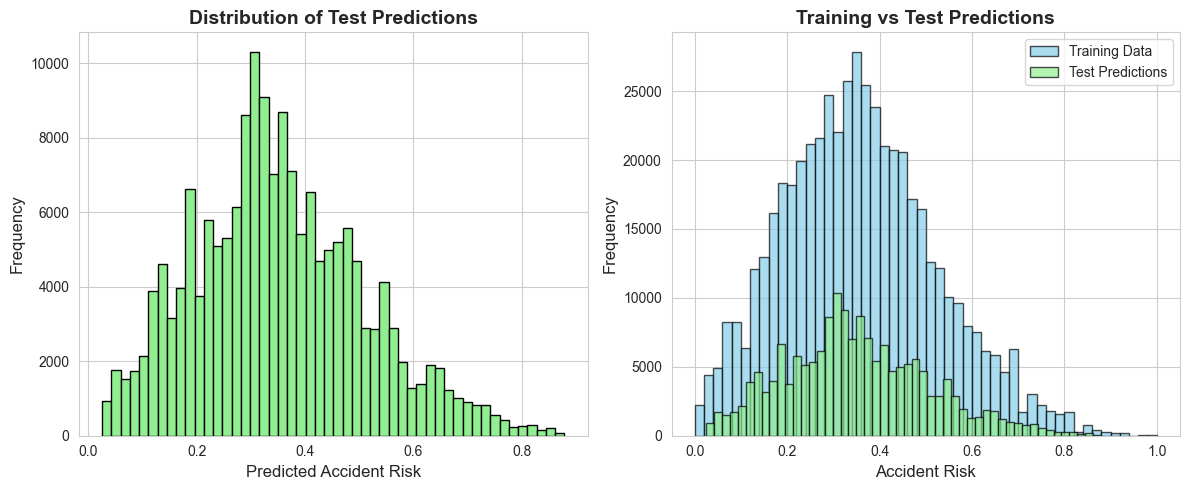

In [25]:
# Visualize the distribution of predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Predicted Accident Risk', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Test Predictions', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
plt.hist(y_train, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Training Data')
plt.hist(test_predictions, bins=50, color='lightgreen', edgecolor='black', alpha=0.7, label='Test Predictions')
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Training vs Test Predictions', fontsize=14, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
print("="*60)
print("🎉 PROJECT COMPLETE!")
print("="*60)

print("\n✅ What you accomplished:")
print("   1. Loaded and explored 517,754 training samples")
print("   2. Visualized data patterns and relationships")
print("   3. Preprocessed data (encoded categorical variables)")
print("   4. Built and trained 2 machine learning models")
print("   5. Evaluated model performance")
print("   6. Made predictions on 172,585 test samples")
print("   7. Created submission file!")

print("\n📁 Files created:")
print("   • my_submission.csv (ready to submit to Kaggle!)")

print("\n🚀 Next steps:")
print("   1. Go to: https://www.kaggle.com/competitions/playground-series-s5e10/submit")
print("   2. Upload 'my_submission.csv'")
print("   3. See your score on the leaderboard!")

print("\n💡 To improve your model, try:")
print("   • Increase n_estimators (e.g., 200, 300)")
print("   • Adjust max_depth")
print("   • Try XGBoost or LightGBM")
print("   • Create new features (feature engineering)")
print("   • Use cross-validation")

print("\n🎓 Congratulations on training your first ML model!")
print("="*60)

🎉 PROJECT COMPLETE!

✅ What you accomplished:
   1. Loaded and explored 517,754 training samples
   2. Visualized data patterns and relationships
   3. Preprocessed data (encoded categorical variables)
   4. Built and trained 2 machine learning models
   5. Evaluated model performance
   6. Made predictions on 172,585 test samples
   7. Created submission file!

📁 Files created:
   • my_submission.csv (ready to submit to Kaggle!)

🚀 Next steps:
   1. Go to: https://www.kaggle.com/competitions/playground-series-s5e10/submit
   2. Upload 'my_submission.csv'
   3. See your score on the leaderboard!

💡 To improve your model, try:
   • Increase n_estimators (e.g., 200, 300)
   • Adjust max_depth
   • Try XGBoost or LightGBM
   • Create new features (feature engineering)
   • Use cross-validation

🎓 Congratulations on training your first ML model!
